### **Dask-Based Random Forest Classifier on US Accident Data**
#### **Introduction:**
This project demonstrates the use of a distributed Random Forest model to classify accident severity using Dask's distributed computing capabilities. We'll:
1. Use a cleaned dataset of US accidents.
2. Preprocess the data.
3. Train multiple Random Forest configurations.
4. Evaluate and visualize the results.


In [1]:
from dask.distributed import Client, LocalCluster
import time
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import MinMaxScaler

In [2]:
! ifconfig

em1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 9000
        inet 10.99.252.133  netmask 255.255.0.0  broadcast 10.99.255.255
        inet6 fe80::425c:fdff:fe81:cbea  prefixlen 64  scopeid 0x20<link>
        ether 40:5c:fd:81:cb:ea  txqueuelen 1000  (Ethernet)
        RX packets 161152277554  bytes 759861724509543 (691.0 TiB)
        RX errors 17891  dropped 0  overruns 0  frame 17891
        TX packets 155857343214  bytes 672134134924612 (611.3 TiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0
        device interrupt 64  memory 0x93000000-937fffff  

lo: flags=73<UP,LOOPBACK,RUNNING>  mtu 65536
        inet 127.0.0.1  netmask 255.0.0.0
        inet6 ::1  prefixlen 128  scopeid 0x10<host>
        loop  txqueuelen 1000  (Local Loopback)
        RX packets 1084864512  bytes 11338178448591 (10.3 TiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 1084864512  bytes 11338178448591 (10.3 TiB)
        TX errors 0  dropped 0 overruns 0  carri

#### 1. Initialize Dask Cluster
This function sets up a Dask cluster with workers and provides a link to the Dask dashboard for monitoring.

##### Args:
1. n_workers (int): Number of worker processes to start.
2. threads_per_worker (int): Number of threads per worker process.
3. memory_limit (str): Memory limit for each worker process.

##### Returns:
tuple: A tuple containing the Dask client and cluster objects.

In [3]:
def initialize_cluster(n_workers, threads_per_worker, memory_limit):
    # Create a local Dask cluster with specified parameters
    cluster = LocalCluster(
        n_workers=n_workers,  # Number of worker processes
        threads_per_worker=threads_per_worker,  # Threads per worker
        memory_limit=memory_limit,  # Memory limit per worker
        processes=True,  # Use separate processes for workers
        host='10.99.252.133'  # Host address for the cluster
    )

    # Create a Dask client to interact with the cluster
    client = Client(cluster)

    # Print the Dask dashboard link for monitoring
    print(f"Dask Dashboard Link: {client.dashboard_link}")

    # Scale the cluster
    # cluster.scale()

    # Return the client and cluster objects
    return client, cluster

#### 2. Data Loading and Preprocessing
This function loads the dataset using Dask, normalizes the features, performs feature engineering, and splits the data into training and test sets.

##### Args:
1. dataset_path (str): Path to the CSV dataset.
2. features (list): List of feature column names.
3. target (str): Name of the target column.

##### Returns:
tuple: Tuple of (X_train, X_test, y_train, y_test)

In [12]:
def data_loading_and_preprocessing(dataset_path, features, target):
    # Read the CSV dataset using Dask DataFrame
    df = dd.read_csv(dataset_path)

    # Select the features and target columns
    X = df[features]
    Y = df[target]

    # Normalize the features using Min-Max scaling
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    # Create new features by multiplying existing features
    X_normalized['Temp_Wind'] = X_normalized['Temperature(F)'] * X_normalized['Wind_Speed(mph)']
    X_normalized['Visibility_Wind'] = X_normalized['Visibility(mi)'] * X_normalized['Wind_Speed(mph)']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized,  # Normalized feature matrix
        Y,  # Target variable
        test_size=0.2,  # 20% of data for testing
        random_state=42,  # Seed for reproducibility
        shuffle=False  # Maintain original data order
    )

    # Compute the results to obtain NumPy arrays
    return X_train.compute(), X_test.compute(), y_train.compute(), y_test.compute()

#### 3. Model Training and Evaluation
This function trains multiple Random Forest models with different configurations and evaluates their performance in terms of accuracy and time.

#### Args:
1. X_train (array): Training features.
2. X_test (array): Testing features.
3. y_train (array): Training target labels.
4. y_test (array): Testing target labels.
5. configurations (dict): Dictionary of hyperparameter configurations.

#### Returns:
dict: Dictionary containing evaluation results for each configuration.

In [5]:
def model_training_and_evaluation(X_train, X_test, y_train, y_test, configurations):

        # Predict labels for the testing data
        y_pred = model.predict(X_test)

        # End time measurement
        end_time = time.time()

        # Calculate accuracy score for the current configuration
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate training and evaluation time
        training_time = end_time - start_time

        # Store results for the current configuration
        results[config_name] = {
            'accuracy': accuracy,
            'time': training_time,
        }

    # Return the dictionary containing evaluation results for all configurations
    return results

#### 4. Visualization
This function generates visualizations of the model performance for accuracy and training time.

#### Args:
1. cluster_results (dict): Dictionary containing cluster performance data.
    - Keys: Configuration names (strings)
    - Values: Dictionaries with performance metrics
        - 'time' (float): Time taken for execution (seconds)
        - 'accuracy' (float): Accuracy score achieved
2. model_results (dict): Dictionary containing model performance data.
    Same structure as cluster_results


In [6]:
def visualize_performance(cluster_results, model_results):
    # Cluster Performance
    cluster_configs = list(cluster_results.keys())
    cluster_times = [cluster_results[config]['time'] for config in cluster_configs]
    cluster_accuracies = [cluster_results[config]['accuracy'] for config in cluster_configs]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Speed (Time) Graph
    ax1.plot(cluster_configs, cluster_times, marker='o', color='orange', linewidth=2)
    ax1.set_ylabel('Time (seconds)', color='orange')
    ax1.set_title('Cluster Configuration Speed')
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # Efficiency (Accuracy) Graph
    ax2.plot(cluster_configs, cluster_accuracies, marker='s', color='blue', linewidth=2)
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.set_title('Cluster Configuration Efficiency')
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Model Performance
    model_configs = list(model_results.keys())
    model_times = [model_results[config]['time'] for config in model_configs]
    model_accuracies = [model_results[config]['accuracy'] for config in model_configs]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Speed (Time) Graph
    ax1.plot(model_configs, model_times, marker='o', color='green', linewidth=2)
    ax1.set_ylabel('Time (seconds)', color='green')
    ax1.set_title('Model Configuration Speed')
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # Efficiency (Accuracy) Graph
    ax2.plot(model_configs, model_accuracies, marker='s', color='purple', linewidth=2)
    ax2.set_ylabel('Accuracy', color='purple')
    ax2.set_title('Model Configuration Efficiency')
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


#### 5. Main Function
The main() function orchestrates the entire process by calling the individual functions.

In [10]:
def main():
    dataset_path = "../final_project/Cleaned_US_Accidents_March23.csv"
    features = ['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
    target = 'Severity'

    # Cluster configurations
    cluster_configs = {
        "4_workers_2_threads": {"n_workers": 4, "threads_per_worker": 2, "memory_limit": "8GB"},
        "6_workers_2_threads": {"n_workers": 6, "threads_per_worker": 2, "memory_limit": "12GB"},
        "8_workers_4_threads": {"n_workers": 8, "threads_per_worker": 4, "memory_limit": "16GB"},
    }

    # Model configurations
    model_configs = {
        'model_uses_8cores': {'n_estimators': 50, 'max_depth': 3, 'random_state': 42, 'n_jobs': 8},
        'model_uses_12cores': {'n_estimators': 100, 'max_depth': 3, 'random_state': 42, 'n_jobs': 12},
        'model_uses_allcores': {'n_estimators': 150, 'max_depth': 5, 'random_state': 42, 'n_jobs': -1},
    }

    cluster_results = {}
    model_results = {}

    for config_name, config_params in cluster_configs.items():
        print(f"Testing {config_name}...")
        client, cluster = initialize_cluster(**config_params)

        try:
            X_train, X_test, y_train, y_test = data_loading_and_preprocessing(
                dataset_path, features, target
            )

            results = model_training_and_evaluation(X_train, X_test, y_train, y_test, model_configs)

            avg_accuracy = sum([res['accuracy'] for res in results.values()]) / len(results)
            total_time = sum([res['time'] for res in results.values()])
            cluster_results[config_name] = {
                "accuracy": avg_accuracy,
                "time": total_time,
            }

            model_results.update(results)

        finally:
            client.close()
            cluster.close()

    visualize_performance(cluster_results, model_results)

Testing 4_workers_2_threads...
Dask Dashboard Link: http://10.99.252.133:8787/status
Testing 6_workers_2_threads...
Dask Dashboard Link: http://10.99.252.133:8787/status
Testing 8_workers_4_threads...
Dask Dashboard Link: http://10.99.252.133:8787/status


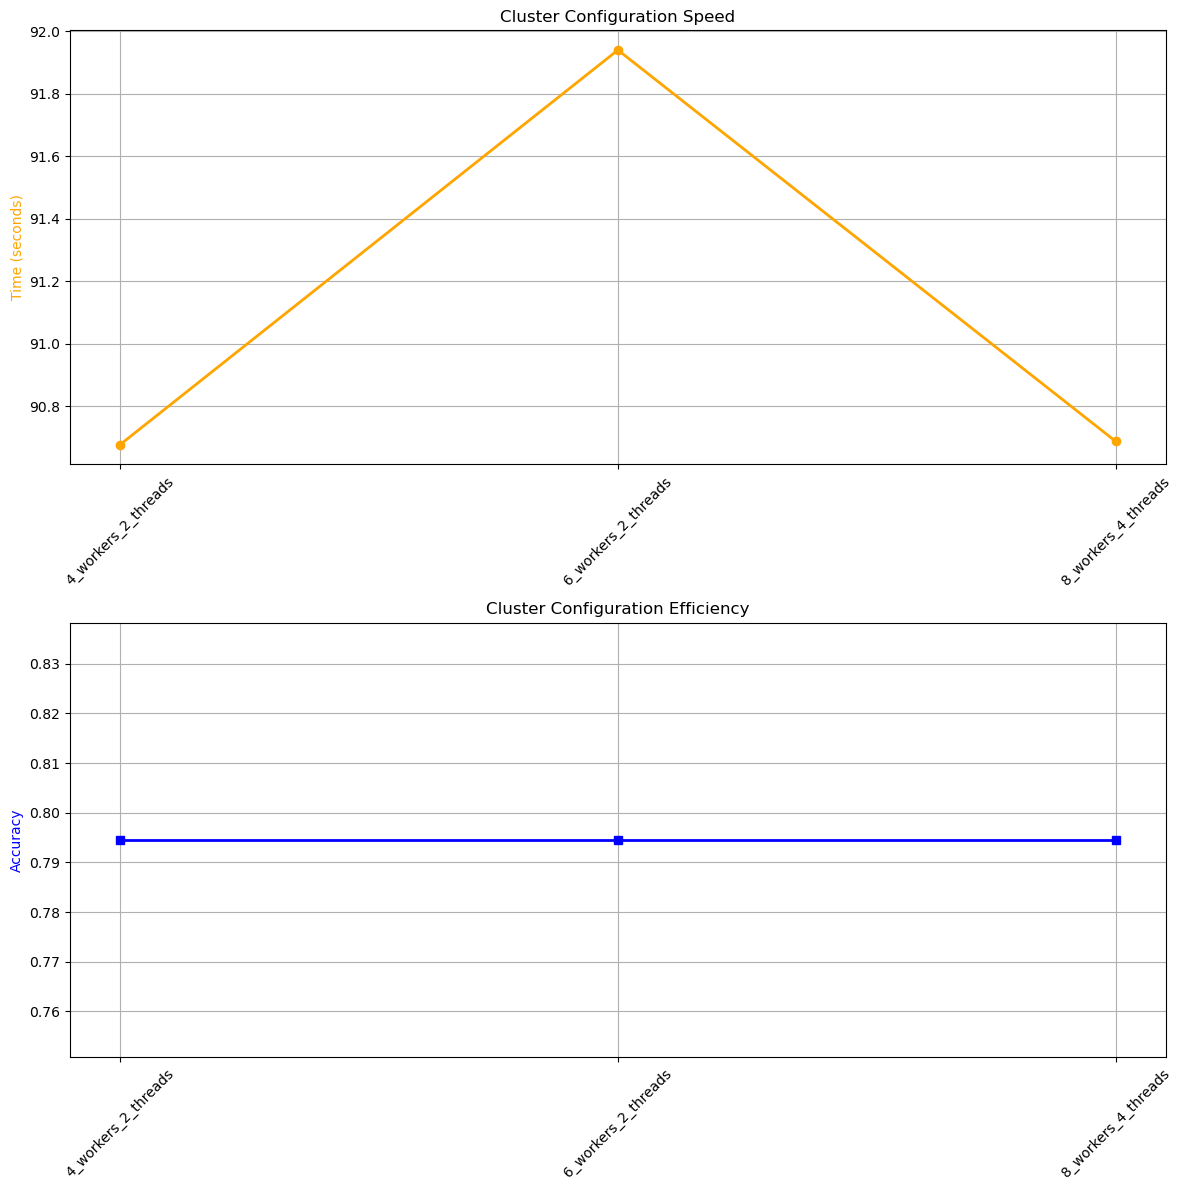

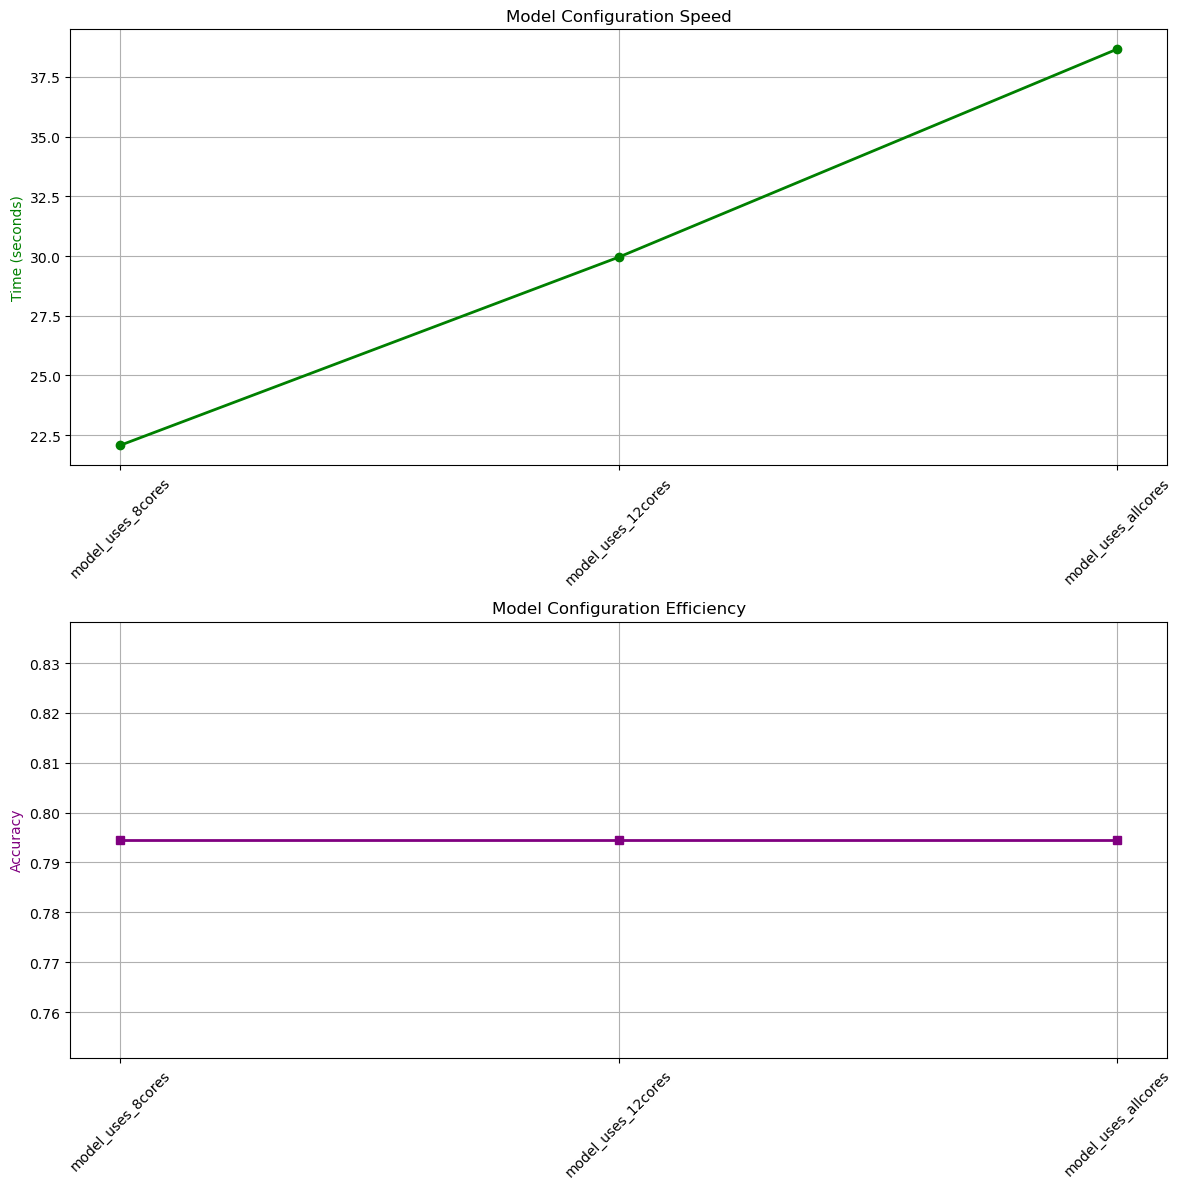

In [11]:
if __name__ == "__main__":
    main()